## Subset data in polar stereographic projection using a shape file fr

> History | Updated August 2024

### Background

Remote sensing data in polar regions commonly use a polar stereographic projection, where the georeferencing is in x and y coordinates instead of the more widely used latitudes and longitudes. Working with data from different projections can be challenging.


### Objectives

In this tutorial, we will learn how download IMS Snow and Ice data in polar stereographic projection and subset them within the boundaries of Lake Iliamna in Alaska, where the lake shape data are presented in a different projection.  

#### The tutorial demonstrates the following techniques

* Download sea ice satellite data from the PolarWatch ERDDAP data server
* Import geographical features of Lake Iliamna from a shapefile
* Transform data from one projection to another
* Subset the satellite data for Lake Iliamna
* Visualize data in different projection


### Data Used

__World Lake shape data__

The world lake shapefile can be downloaded from ArcGIS Hub at https://hub.arcgis.com, and is also available in the `resource/` directory of this tutorial folder. The file includes geographical features of all world lakes. For this exercise, only the features of Lake Illemna will be used.


__IMS Snow and Ice Analysis, Arctic, 4km, 2004 - Present, Daily__ ([PolarWatch Preview](https://polarwatch.noaa.gov/catalog/ice-nrt-nh-ims/preview/?dataset=4-km&var=IMS_Surface_Values&time_min=2024-08-21T00:00:00Z&time_max=2024-08-21T00:00:00Z&proj=epsg3413&colorBar=rainbow|discrete||0|5|5))

The IMS dataset includes daily snow and ice coverage data for the Arctic with a 4-km resolution, available starting from 2004. The values in the dataset are categorical, representing five categories: 0 for areas outside the coverage zone, 1 for open water, 2 for land without snow, 3 for sea ice or lake ice, and 4 for snow-covered land.  Data with a 1-km resolution are also available.  Please contact us for more information.

#### Load python packages

For this exercise, the following packages are required.  The complete list of required packages for all tutorials is provided in the `environment.yml` located in the `Python-setup/` folder.


In [3]:
# Load packages
import xarray as xr
import geopandas as gpd
import pandas as pd
import rioxarray
from shapely.geometry import mapping

#### Load Lake Illemna data

In [4]:
# Load lake shape file
shapefile_path = '../resources/World_Lakes_shapes/World_Lakes.shp'
lakes_shp = gpd.read_file(shapefile_path)

In [5]:
# Check column names
print("Lake Data Columns:")
print(lakes_shp.columns)

Lake Data Columns:
Index(['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src',
       'Lake_type', 'Grand_id', 'Lake_area', 'Shore_len', 'Shore_dev',
       'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time',
       'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat',
       'geometry'],
      dtype='object')


In [6]:
# Look up Iliamna lake
print("Row(s) that contain lake name: Iliamna")
lakes_shp[lakes_shp['Lake_name'].str.contains('iliamna', case=False, na=False)]

Row(s) that contain lake name: Iliamna


,Hylak_id,Lake_name,Country,Continent,Poly_src,Lake_type,Grand_id,Lake_area,Shore_len,Shore_dev,...,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat,geometry
287,31,Iliamna,United States of America,North America,NHD,1,0,2634.62,1006.79,5.53,...,1,43.8,354.811,3761.5,13,-1.0,16869.4,-155.884538,59.331889,"POLYGON ((-17336380.000 8247763.000, -17336837..."


In [7]:
# Get Iliamna Lake shape from the World lakes shapefile (Hylak_id = 31)
iliamna_shp = lakes_shp[lakes_shp['Hylak_id'] == 31]

In [8]:
# Examine coordinate referernce system (crs)
iliamna_shp.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

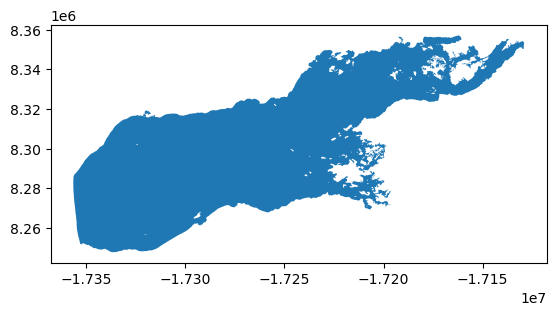

In [9]:
# Visualize the lake 
iliamna_shp.plot()

#### Load IMS data from PolarWatch ERDDAP

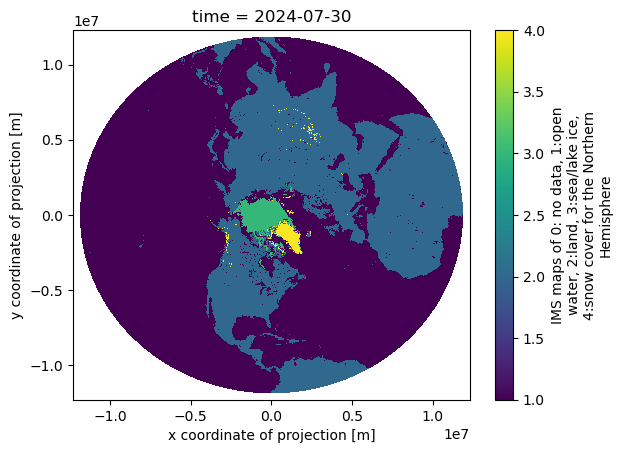

In [10]:
# Load IMS data from ERDDAP
erddap_url = "https://polarwatch.noaa.gov/erddap/griddap/usnic_ims_4km"
ds = xr.open_dataset(erddap_url)

# Select one day data
ds_date = '2024-07-30'
ds = ds.sel(time=ds_date)

# Visualize the IMS data
ds["IMS_Surface_Values"].plot()


In [11]:
# Check the IMS data projection
ds.attrs['grid_mapping_proj4']

'+proj=stere +lat_0=90 +lat_ts=60 +lon_0=-80 +k=1 +x_0=0 +y_0=0 +a=6378137 +b=6356257 +units=m +no_defs'

### Transform the lake data crs to match the satellite data crs

The helper functions are provided for the projection transformation process


In [12]:
# from PolarWatch helper functions

def set_geo_specs(dat: xr.DataArray, xdim: str, ydim: str, crs: str) -> xr.DataArray:
    """Update the spatial dimensions and coordinate reference system (CRS) of an xarray DataArray.

    Args:
        dat (xr.DataArray): The data array to modify.
        xdim (str): Name of the dimension representing the x-coordinate.
        ydim (str): Name of the dimension representing the y-coordinate.
        crs (str): String representation of the coordinate reference system to assign.

    Returns:
        xr.DataArray: The updated data array with specified spatial dimensions and CRS.
    """
    dat = dat.rio.set_spatial_dims(x_dim=xdim, y_dim=ydim)
    try:
        dat = dat.rio.write_crs(crs)
        print('CRS setup successful')
    except Exception as e:
        print(f'Error during crs setup: {e}')

    return dat


def clip_data_to_shapefile(data_array: xr.DataArray, shapefile_geom, crs: str):
    """Clip data array to the specified shapefile geometry with CRS.
    
    Args:
        data_array (xr.DataArray): The data array to modify.
        shapefile_geom : Shapefile geometry.
        crs (str): CRS of the data.

    Returns:
        xr.DataArray: The updated data array with specified spatial dimensions and CRS.  
    
    """
    try:
        clipped_data = data_array.rio.clip(shapefile_geom.apply(mapping), crs)
        print("Clipping successful")
        return clipped_data
    except Exception as e:
        print(f"Error during clipping: {e}")
        raise

def transform_shapes(shp: gpd.GeoDataFrame, crs:str):
    # Transform projection to Polar Stereographic Projection
    try:
        shp_proj_transformed = shp.to_crs(crs)
        print(f"Projection transformed to {crs}")
        return shp_proj_transformed
    except Exception as e:
        print(f"Error transforming CRS: {e}")
        raise

In [18]:
# Set crs_project as the data crs (based on xarray.Dataset.attrs)
crs_project = "+proj=stere +lat_0=90 +lat_ts=60 +lon_0=-80 +k=1 +x_0=0 +y_0=0 +a=6378137 +b=6356257 +units=m +no_defs"

# Set data crs
ds = set_geo_specs(ds, xdim="x", ydim="y", crs=crs_project)

# Transform the shape into the data crs
iliamna_transformed = transform_shapes(iliamna_shp, crs_project)


CRS setup successful
Projection transformed to +proj=stere +lat_0=90 +lat_ts=60 +lon_0=-80 +k=1 +x_0=0 +y_0=0 +a=6378137 +b=6356257 +units=m +no_defs


In [19]:
# Examine lake shape crs
iliamna_transformed.crs

<Projected CRS: +proj=stere +lat_0=90 +lat_ts=60 +lon_0=-80 +k=1 + ...>
Name: unknown
Axis Info [cartesian]:
- E[south]: Easting (metre)
- N[south]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Polar Stereographic (variant B)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

<Axes: >

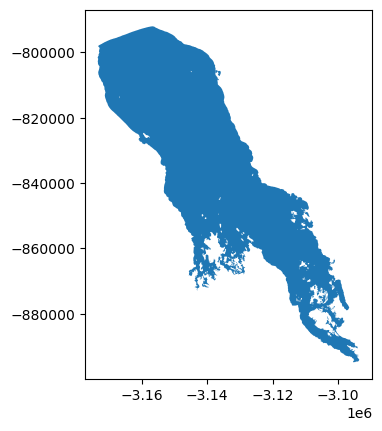

In [15]:
# Visualized transformed iliamna shape
iliamna_transformed.plot()

#### Subset the satellite data using the Lake shape

In [16]:
# Clip data to the shape
ds_clipped = clip_data_to_shapefile(ds, iliamna_transformed.geometry, iliamna_transformed.crs)

Clipping successful


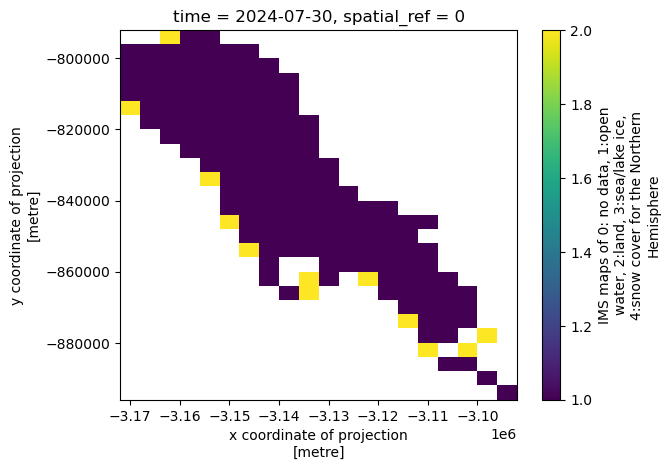

In [17]:
# Visualized clipped data
ds_clipped["IMS_Surface_Values"].plot()

### Resources

* [CoastWatch Learning Portal](https://umd.instructure.com/courses/1336575) - Lectures, Videos, Other learning resources
* [CoastWatch Tutorials on Github](https://github.com/coastwatch-training/CoastWatch-Tutorials) - Tutorial notebooks and code samples

* [PolarWatch ERDDAP](https://polarwatch.noaa.gov/erddap/) - Complete list of data available on PolarWatch ERDDAP Server
* [PolarWatch Catalog](https://polarwatch.noaa.gov/catalog/list.php) - Preview data on polar map 
